In [2]:
import h2o
from h2o.estimators.glm import H2OGeneralizedLinearEstimator
from h2o.grid.grid_search import H2OGridSearch 
h2o.init(max_mem_size='2G')  # give h2o as much memory as possible
h2o.no_progress() # turn off h2o progress bars

import numpy as np
import pandas as pd

Checking whether there is an H2O instance running at http://localhost:54321. connected.


H2O cluster uptime:,14 secs
H2O cluster version:,3.10.4.8
H2O cluster version age:,1 month and 1 day
H2O cluster name:,H2O_from_python_youdan_h2ikwk
H2O cluster total nodes:,1
H2O cluster free memory:,1.921 Gb
H2O cluster total cores:,1
H2O cluster allowed cores:,1
H2O cluster status:,"locked, healthy"
H2O connection url:,http://localhost:54321
H2O connection proxy:,None


In [3]:
train = h2o.import_file('/home/youdan/Documents/ML_House price/train.csv')
test = h2o.import_file('/home/youdan/Documents/ML_House price/test.csv')

# bug fix - from Keston
dummy_col = np.random.rand(test.shape[0])
test = test.cbind(h2o.H2OFrame(dummy_col))
cols = test.columns
cols[-1] = 'SalePrice'
test.columns = cols
print(train.shape)
print(test.shape)

(1460, 81)
(1459, 81)


In [4]:
def get_type_lists(frame=train, rejects=['Id', 'SalePrice']):

    """Creates lists of numeric and categorical variables.
    
    :param frame: The frame from which to determine types.
    :param rejects: Variable names not to be included in returned lists.
    :return: Tuple of lists for numeric and categorical variables in the frame.
    
    """
    
    nums, cats = [], []
    for key, val in frame.types.items():
        if key not in rejects:
            if val == 'enum':
                cats.append(key)
            else: 
                nums.append(key)
                
    print('Numeric =', nums)                
    print()
    print('Categorical =', cats)
    
    return nums, cats

In [5]:
original_nums, cats = get_type_lists()

Numeric = ['MiscVal', 'GarageCars', 'BedroomAbvGr', 'TotRmsAbvGrd', 'Fireplaces', 'BsmtUnfSF', 'YrSold', '2ndFlrSF', 'GrLivArea', 'YearBuilt', 'PoolArea', '3SsnPorch', 'TotalBsmtSF', 'BsmtFinSF2', 'OverallQual', 'OpenPorchSF', 'MoSold', 'HalfBath', 'GarageYrBlt', 'EnclosedPorch', 'BsmtHalfBath', '1stFlrSF', 'BsmtFinSF1', 'MSSubClass', 'MasVnrArea', 'YearRemodAdd', 'GarageArea', 'ScreenPorch', 'LotArea', 'KitchenAbvGr', 'WoodDeckSF', 'FullBath', 'LowQualFinSF', 'OverallCond', 'BsmtFullBath', 'LotFrontage']

Categorical = ['Neighborhood', 'Exterior1st', 'LandSlope', 'Functional', 'CentralAir', 'Alley', 'BsmtCond', 'LotConfig', 'HouseStyle', 'GarageType', 'Exterior2nd', 'FireplaceQu', 'BldgType', 'RoofMatl', 'GarageCond', 'BsmtQual', 'ExterQual', 'BsmtExposure', 'Fence', 'PavedDrive', 'LandContour', 'Street', 'MasVnrType', 'ExterCond', 'Utilities', 'LotShape', 'SaleType', 'MSZoning', 'Condition2', 'GarageQual', 'RoofStyle', 'GarageFinish', 'Heating', 'Condition1', 'PoolQC', 'SaleCondition

In [6]:
train, valid = train.split_frame([0.7], seed=12345)
print(train.shape)
print(valid.shape)

(1001, 81)
(459, 81)


In [7]:
# median usually better than mean
# (_ signifies temporary throw-away variable, used to suppress output)
_ = train[['MasVnrArea', 'GarageYrBlt', 'LotFrontage']].impute(method='median')
_ = valid[['MasVnrArea', 'GarageYrBlt', 'LotFrontage']].impute(method='median')
_ = test[['BsmtHalfBath', 'BsmtFinSF1', 'BsmtFullBath', 'BsmtFinSF2', 'BsmtUnfSF', 'MasVnrArea', 
          'GarageYrBlt', 'LotFrontage', 'GarageCars', 'TotalBsmtSF', 'GarageArea']].impute(method='median')

In [8]:
def target_encoder(training_frame, test_frame, x, y, lambda_=0.15, threshold=150, test=False):

    """ Applies simple target encoding to categorical variables.

    :param training_frame: Training frame which to create target means and to be encoded.
    :param test_frame: Test frame to be encoded using information from training frame.
    :param x: Name of input variable to be encoded.
    :param y: Name of target variable to use for encoding.
    :param lambda_: Balance between level mean and overall mean for small groups.
    :param threshold: Number below which a level is considered small enough to be shrunken.
    :param test: Whether or not to print the row_val_dict for testing purposes.
    :return: Tuple of encoded variable from train and test set as H2OFrames.

    """

    # convert to pandas
    trdf = training_frame.as_data_frame().loc[:, [x,y]] # df
    tss = test_frame.as_data_frame().loc[:, x]          # series


    # create dictionary of level:encode val

    encode_name = x + '_Tencode'
    overall_mean = trdf[y].mean()
    row_val_dict = {}

    for level in trdf[x].unique():
        level_df = trdf[trdf[x] == level][y]
        level_n = level_df.shape[0]
        level_mean = level_df.mean()
        if level_n >= threshold:
            row_val_dict[level] = level_mean
        else:
            row_val_dict[level] = ((1 - lambda_) * level_mean) +\
                                  (lambda_ * overall_mean)

    row_val_dict[np.nan] = overall_mean # handle missing values

    if test:
        print(row_val_dict)

    # apply the transform to training data
    trdf[encode_name] = trdf[x].apply(lambda i: row_val_dict[i])

    # apply the transform to test data
    tsdf = pd.DataFrame(columns=[x, encode_name])
    tsdf[x] = tss
    tsdf.loc[:, encode_name] = overall_mean # handle previously unseen values
    # handle values that are seen in tsdf but not row_val_dict
    for i, col_i in enumerate(tsdf[x]):
        try:
            row_val_dict[col_i]
        except:
            # a value that appeared in tsdf isn't in the row_val_dict so just
            # make it the overall_mean
            row_val_dict[col_i] = overall_mean
    tsdf[encode_name] = tsdf[x].apply(lambda i: row_val_dict[i])


    # convert back to H2O

    trdf = h2o.H2OFrame(trdf[encode_name].as_matrix())
    trdf.columns = [encode_name]

    tsdf = h2o.H2OFrame(tsdf[encode_name].as_matrix())
    tsdf.columns = [encode_name]

    return (trdf, tsdf)

In [9]:
total = len(cats)
for i, var in enumerate(cats):
    
    tr_enc, _ = target_encoder(train, test, var, 'SalePrice')
    v_enc, ts_enc = target_encoder(valid, test, var, 'SalePrice')
    
    print('Encoding: ' + var + ' (' + str(i+1) + '/' + str(total) + ') ...')

    train = train.cbind(tr_enc)
    valid = valid.cbind(v_enc)
    test = test.cbind(ts_enc)    
    
print('Done.')

Encoding: Neighborhood (1/43) ...
Encoding: Exterior1st (2/43) ...
Encoding: LandSlope (3/43) ...
Encoding: Functional (4/43) ...
Encoding: CentralAir (5/43) ...
Encoding: Alley (6/43) ...
Encoding: BsmtCond (7/43) ...
Encoding: LotConfig (8/43) ...
Encoding: HouseStyle (9/43) ...
Encoding: GarageType (10/43) ...
Encoding: Exterior2nd (11/43) ...
Encoding: FireplaceQu (12/43) ...
Encoding: BldgType (13/43) ...
Encoding: RoofMatl (14/43) ...
Encoding: GarageCond (15/43) ...
Encoding: BsmtQual (16/43) ...
Encoding: ExterQual (17/43) ...
Encoding: BsmtExposure (18/43) ...
Encoding: Fence (19/43) ...
Encoding: PavedDrive (20/43) ...
Encoding: LandContour (21/43) ...
Encoding: Street (22/43) ...
Encoding: MasVnrType (23/43) ...
Encoding: ExterCond (24/43) ...
Encoding: Utilities (25/43) ...
Encoding: LotShape (26/43) ...
Encoding: SaleType (27/43) ...
Encoding: MSZoning (28/43) ...
Encoding: Condition2 (29/43) ...
Encoding: GarageQual (30/43) ...
Encoding: RoofStyle (31/43) ...
Encoding: Ga

In [10]:
encoded_nums, cats = get_type_lists(frame=train)

Numeric = ['FireplaceQu_Tencode', 'MiscFeature_Tencode', 'CentralAir_Tencode', 'MiscVal', 'GarageCars', 'RoofMatl_Tencode', 'BedroomAbvGr', 'Fence_Tencode', 'BsmtCond_Tencode', 'TotRmsAbvGrd', 'Exterior2nd_Tencode', 'BsmtQual_Tencode', 'Fireplaces', 'ExterQual_Tencode', 'BsmtUnfSF', 'YrSold', '2ndFlrSF', 'GrLivArea', 'Functional_Tencode', 'YearBuilt', 'PoolArea', 'MSZoning_Tencode', 'BldgType_Tencode', 'SaleCondition_Tencode', 'LandSlope_Tencode', '3SsnPorch', 'Exterior1st_Tencode', 'TotalBsmtSF', '1stFlrSF', 'Heating_Tencode', 'LandContour_Tencode', 'Utilities_Tencode', 'BsmtFinSF2', 'OverallQual', 'OpenPorchSF', 'MoSold', 'HalfBath', 'Electrical_Tencode', 'HeatingQC_Tencode', 'SaleType_Tencode', 'Condition2_Tencode', 'PoolQC_Tencode', 'GarageCond_Tencode', 'EnclosedPorch', 'BsmtHalfBath', 'MasVnrType_Tencode', 'LotShape_Tencode', 'BsmtFinSF1', 'KitchenQual_Tencode', 'RoofStyle_Tencode', 'LotConfig_Tencode', 'Alley_Tencode', 'PavedDrive_Tencode', 'Neighborhood_Tencode', 'MasVnrArea', 

In [11]:
print('Imputed and encoded numeric training data:')
train[encoded_nums].describe() #79 numeric columns w/ no missing
print('--------------------------------------------------------------------------------')
print('Imputed and encoded numeric validation data:')
valid[encoded_nums].describe() #79 numeric columns w/ no missing
print('--------------------------------------------------------------------------------')
print('Imputed and encoded numeric test data:')
test[encoded_nums].describe() #79 numeric columns w/ no missing

Imputed and encoded numeric training data:
Rows:1001
Cols:79




,FireplaceQu_Tencode,MiscFeature_Tencode,CentralAir_Tencode,MiscVal,GarageCars,RoofMatl_Tencode,BedroomAbvGr,Fence_Tencode,BsmtCond_Tencode,TotRmsAbvGrd,Exterior2nd_Tencode,BsmtQual_Tencode,Fireplaces,ExterQual_Tencode,BsmtUnfSF,YrSold,2ndFlrSF,GrLivArea,Functional_Tencode,YearBuilt,PoolArea,MSZoning_Tencode,BldgType_Tencode,SaleCondition_Tencode,LandSlope_Tencode,3SsnPorch,Exterior1st_Tencode,TotalBsmtSF,1stFlrSF,Heating_Tencode,LandContour_Tencode,Utilities_Tencode,BsmtFinSF2,OverallQual,OpenPorchSF,MoSold,HalfBath,Electrical_Tencode,HeatingQC_Tencode,SaleType_Tencode,Condition2_Tencode,PoolQC_Tencode,GarageCond_Tencode,EnclosedPorch,BsmtHalfBath,MasVnrType_Tencode,LotShape_Tencode,BsmtFinSF1,KitchenQual_Tencode,RoofStyle_Tencode,LotConfig_Tencode,Alley_Tencode,PavedDrive_Tencode,Neighborhood_Tencode,MasVnrArea,GarageYrBlt,YearRemodAdd,GarageArea,GarageType_Tencode,ScreenPorch,LotArea,BsmtFinType1_Tencode,MSSubClass,GarageFinish_Tencode,BsmtFinType2_Tencode,Street_Tencode,KitchenAbvGr,GarageQual_Tencode,BsmtExposure_Tencode,ExterCond_Tencode,WoodDeckSF,FullBath,LowQualFinSF,BsmtFullBath,Foundation_Tencode,HouseStyle_Tencode,OverallCond,Condition1_Tencode,LotFrontage
type,real,real,real,int,int,real,int,real,real,int,real,real,int,real,int,int,int,int,real,int,int,real,real,real,real,int,real,int,int,real,real,real,int,int,int,int,int,real,real,real,real,real,real,int,int,real,real,int,real,real,real,real,real,real,real,real,int,int,real,int,int,real,int,real,real,real,int,real,real,real,int,int,int,int,real,real,int,real,real
mins,141462.34885614386,140375.79385614386,119608.23368665231,0.0,0.0,143775.79385614386,0.0,141306.73814185814,84275.79385614385,3.0,129978.23968947721,121216.12093947716,0.0,116078.96885614384,0.0,2006.0,0.0,480.0,110059.12718947718,1875.0,0.0,78614.79385614385,138273.46052281052,115832.04385614385,181486.5182747485,0.0,78325.79385614385,0.0,480.0,93469.96052281052,145140.16285614387,144200.79385614386,0.0,2.0,0.0,1.0,0.0,84275.79385614385,135668.69902855766,125968.29385614385,108075.79385614385,182171.95904095902,112070.79385614385,0.0,0.0,155578.6188811189,163944.59385614382,0.0,124936.94820396995,161577.2224275724,176473.2899159664,128075.200999001,129253.89464979463,109690.79385614385,0.0,1908.0,1950.0,0.0,125174.9605228105,0.0,1300.0,150410.4464877228,20.0,141354.57177033494,154536.9355228105,146350.10385614386,0.0,96813.29385614385,167645.4123076923,122047.14941169939,0.0,0.0,0.0,0.0,121726.89385614387,118907.22242757239,2.0,134468.29385614386,21.0
mean,200266.80114860163,181198.19224147475,182822.70708043198,39.684315684315685,1.7932067932067928,182033.940055499,2.871128871128871,177450.87030976015,184043.11900766572,6.512487512487513,183994.52609268858,182245.41278741238,0.6203796203796205,181095.69602749895,575.99000999001,2007.8281718281721,341.7872127872128,1519.8011988011988,182576.245336881,1972.2987012987012,3.3766233766233764,183387.92640181998,182849.79797600006,181541.32494458588,182145.0556687069,3.4565434565434567,183565.7137941479,1063.2387612387622,1172.0889110889111,182323.57985955104,182186.7329973224,182178.65314071544,41.64935064935065,6.144855144855144,44.92407592407592,6.362637362637364,0.38161838161838163,182952.64128239398,182409.7085632649,181180.3311701286,182224.4420403772,182802.8256832079,186002.74671607107,21.257742257742255,0.059940059940059943,180574.40004970055,181993.92786324568,445.5994005994006,180810.97023994982,182159.00869385363,181772.161181426,180171.38546862724,182908.18055950044,182171.95904095905,106.91146881287725,1978.7345225603353,1985.1388611388606,477.4685314685315,185255.62265751231,14.763236763236764,10628.262737262741,185645.7951523501,57.08791208791207,185712.8721618042,184056.75787594027,182203.53498429657,1.0469530469530466,186018.3297154892,182844.62529074325,182637.2350592465,91.07392607392606,1.5744255744255748,5.9250749250749255,0.4265734265734267,183119.90242260235,183188.25635258848,5.583416583416583,182645.11776425372,70.59975669099758

--------------------------------------------------------------------------------
Imputed and encoded numeric validation data:
Rows:459
Cols:79




,FireplaceQu_Tencode,MiscFeature_Tencode,CentralAir_Tencode,MiscVal,GarageCars,RoofMatl_Tencode,BedroomAbvGr,Fence_Tencode,BsmtCond_Tencode,TotRmsAbvGrd,Exterior2nd_Tencode,BsmtQual_Tencode,Fireplaces,ExterQual_Tencode,BsmtUnfSF,YrSold,2ndFlrSF,GrLivArea,Functional_Tencode,YearBuilt,PoolArea,MSZoning_Tencode,BldgType_Tencode,SaleCondition_Tencode,LandSlope_Tencode,3SsnPorch,Exterior1st_Tencode,TotalBsmtSF,1stFlrSF,Heating_Tencode,LandContour_Tencode,Utilities_Tencode,BsmtFinSF2,OverallQual,OpenPorchSF,MoSold,HalfBath,Electrical_Tencode,HeatingQC_Tencode,SaleType_Tencode,Condition2_Tencode,PoolQC_Tencode,GarageCond_Tencode,EnclosedPorch,BsmtHalfBath,MasVnrType_Tencode,LotShape_Tencode,BsmtFinSF1,KitchenQual_Tencode,RoofStyle_Tencode,LotConfig_Tencode,Alley_Tencode,PavedDrive_Tencode,Neighborhood_Tencode,MasVnrArea,GarageYrBlt,YearRemodAdd,GarageArea,GarageType_Tencode,ScreenPorch,LotArea,BsmtFinType1_Tencode,MSSubClass,GarageFinish_Tencode,BsmtFinType2_Tencode,Street_Tencode,KitchenAbvGr,GarageQual_Tencode,BsmtExposure_Tencode,ExterCond_Tencode,WoodDeckSF,FullBath,LowQualFinSF,BsmtFullBath,Foundation_Tencode,HouseStyle_Tencode,OverallCond,Condition1_Tencode,LotFrontage
type,real,real,real,int,int,real,int,real,real,int,real,real,int,real,int,int,int,int,real,int,int,real,real,real,real,int,real,int,int,real,real,real,int,int,int,int,int,real,real,real,real,real,real,int,int,real,real,int,real,real,real,real,real,real,real,real,int,int,real,int,int,real,int,real,real,real,int,real,real,real,int,int,int,int,real,real,int,real,real
mins,133191.52450980392,73479.02450980392,111601.52450980392,0.0,0.0,175904.02450980392,0.0,133419.96200980392,78579.02450980392,2.0,106204.02450980392,134771.7517825312,0.0,91042.14950980392,0.0,2006.0,0.0,334.0,84954.02450980392,1872.0,0.0,118217.35784313723,128987.56617647059,143816.52450980392,175531.83179723503,0.0,96429.02450980392,0.0,334.0,77729.02450980392,163075.56297134238,178193.4967320261,0.0,1.0,0.0,1.0,0.0,100143.52450980392,100679.02450980392,107734.02450980392,84954.02450980392,178193.4967320261,118776.94117647059,0.0,0.0,131576.52450980392,163981.4191419142,0.0,105130.89950980392,139864.02450980392,165751.57330498463,134607.54723707662,114840.96895424835,112866.7168174962,0.0,1900.0,1950.0,0.0,111434.07450980392,0.0,1491.0,146338.19117647054,20.0,143948.79679144386,145091.52450980392,95579.02450980392,1.0,134853.20367647058,161376.63366336632,91754.02450980392,0.0,0.0,0.0,0.0,110363.31736694675,122402.59593837534,1.0,150223.0311764706,21.0
mean,194587.77315419997,177409.6635197288,179115.18492887355,51.78649237472766,1.710239651416122,177969.71943483272,2.8562091503267975,173941.1787702735,180413.2355397497,6.529411764705884,179728.6088213935,179069.59942970655,0.5969498910675382,174940.2994916485,548.1590413943355,2007.7886710239645,358.3442265795207,1506.0043572984753,178425.73264556364,1969.0196078431372,1.411764705882353,179328.32668845312,178649.1491050451,177335.48292323464,177815.9926203597,3.30718954248366,179651.10523303004,1044.7603485838783,1141.9912854030501,178371.04867785895,177854.22806185653,178193.49673202608,57.23529411764707,6.0,50.44662309368194,6.233115468409586,0.38562091503267976,179083.62772865137,180663.6615169379,177239.6370242215,178197.18104147975,178198.69396030012,184432.01265538894,23.47276688453159,0.05228758169934641,176108.20460862629,176786.222382417,439.36601307189545,177298.2844312017,177381.14581571188,178163.26637404418,176164.9969256838,179002.96058140037,178193.49673202622,96.68340611353712,1977.9953051643195,1984.2701525054467,463.1917211328976,185134.53079371178,15.710239651416122,10273.808278867104,180031.30962236744,56.48148148148149,181122.0343137255,180587.6997415524,178225.25931265752,1.0457516339869284,184195.20382758768,178366.11043615706,178484.556313811,101.15904139433553,1.5446623093681917,5.668845315904139,0.4226579520697168,179041.90369302404,177648.76674783204,5.557734204793029,178617.62590029472,68.85751978891818
maxs,345181.5245

--------------------------------------------------------------------------------
Imputed and encoded numeric test data:
Rows:1459
Cols:79




,FireplaceQu_Tencode,MiscFeature_Tencode,CentralAir_Tencode,MiscVal,GarageCars,RoofMatl_Tencode,BedroomAbvGr,Fence_Tencode,BsmtCond_Tencode,TotRmsAbvGrd,Exterior2nd_Tencode,BsmtQual_Tencode,Fireplaces,ExterQual_Tencode,BsmtUnfSF,YrSold,2ndFlrSF,GrLivArea,Functional_Tencode,YearBuilt,PoolArea,MSZoning_Tencode,BldgType_Tencode,SaleCondition_Tencode,LandSlope_Tencode,3SsnPorch,Exterior1st_Tencode,TotalBsmtSF,1stFlrSF,Heating_Tencode,LandContour_Tencode,Utilities_Tencode,BsmtFinSF2,OverallQual,OpenPorchSF,MoSold,HalfBath,Electrical_Tencode,HeatingQC_Tencode,SaleType_Tencode,Condition2_Tencode,PoolQC_Tencode,GarageCond_Tencode,EnclosedPorch,BsmtHalfBath,MasVnrType_Tencode,LotShape_Tencode,BsmtFinSF1,KitchenQual_Tencode,RoofStyle_Tencode,LotConfig_Tencode,Alley_Tencode,PavedDrive_Tencode,Neighborhood_Tencode,MasVnrArea,GarageYrBlt,YearRemodAdd,GarageArea,GarageType_Tencode,ScreenPorch,LotArea,BsmtFinType1_Tencode,MSSubClass,GarageFinish_Tencode,BsmtFinType2_Tencode,Street_Tencode,KitchenAbvGr,GarageQual_Tencode,BsmtExposure_Tencode,ExterCond_Tencode,WoodDeckSF,FullBath,LowQualFinSF,BsmtFullBath,Foundation_Tencode,HouseStyle_Tencode,OverallCond,Condition1_Tencode,LotFrontage
type,real,real,real,int,real,real,int,real,real,int,real,real,int,real,real,int,int,int,real,int,int,real,real,real,real,int,real,real,int,real,real,real,real,int,int,int,int,real,real,real,real,real,real,int,real,real,real,real,real,real,real,real,real,real,real,real,int,real,real,int,int,real,int,real,real,real,int,real,real,real,int,int,int,real,real,real,int,real,real
mins,133191.52450980392,73479.02450980392,111601.52450980392,0.0,0.0,175904.02450980392,0.0,133419.96200980392,78579.02450980392,3.0,106204.02450980392,134771.7517825312,0.0,91042.14950980392,0.0,2006.0,0.0,407.0,84954.02450980392,1879.0,0.0,118217.35784313723,128987.56617647059,143816.52450980392,175531.83179723503,0.0,96429.02450980392,0.0,407.0,77729.02450980392,163075.56297134238,178193.4967320261,0.0,1.0,0.0,1.0,0.0,100143.52450980392,100679.02450980392,107734.02450980392,127029.02450980392,178193.4967320261,118776.94117647059,0.0,0.0,131576.52450980392,163981.4191419142,0.0,105130.89950980392,139864.02450980392,165751.57330498463,134607.54723707662,114840.96895424835,112866.7168174962,0.0,1895.0,1950.0,0.0,111434.07450980392,0.0,1470.0,146338.19117647054,20.0,143948.79679144386,145091.52450980392,95579.02450980392,0.0,134853.20367647058,161376.63366336632,91754.02450980392,0.0,0.0,0.0,0.0,110363.31736694675,122402.59593837534,1.0,150223.0311764706,21.0
mean,194452.82035270391,177606.24421888925,179789.60281035834,58.16792323509253,1.766117969821674,176751.75320615343,2.8540095956134337,174246.97835710915,179283.61725237893,6.385195339273475,180995.2353182515,181062.10689687656,0.5812200137080192,177673.68837649442,554.2949245541837,2007.7697052775877,325.96778615490064,1486.0459218642907,178383.03720943845,1971.3577793008913,1.7443454420836189,179232.0904301917,178370.36965515942,176492.09637795313,177395.21920765386,1.794379712131597,179810.68688120894,1046.1179698216738,1156.5346127484581,179140.34833949365,179174.22633752605,178193.4967320261,52.61934156378602,6.078821110349555,48.3139136394791,6.104180945853324,0.37765592871830034,180126.11931528104,182227.81273899964,175933.10715345867,178369.39980873468,178193.4967320261,184620.93755108098,24.243317340644268,0.06520247083047358,178207.0798692451,176844.0836371834,439.2037037037038,179340.3962464452,177370.70371664222,178278.00897433652,176172.85149770897,177090.15440559448,179660.93185381076,100.70914127423822,1977.7212165097756,1983.6627827278958,472.76886145404643,186339.7089378328,17.064427690198766,9819.161069225493,182091.99147253155,57.37834132967788,180987.1789957136,180689.57815766838,178065.09267032953,1.042494859492803,182567.66333366183,179354.86101843632,178138.29247727426,93.17477724468819,1.570938999314599,3.5435229609321452,0.4344543582704188,181006.29018575928,176296.0327526844,5.553803975325566,179939.77372747517,68.

In [12]:
# Check Neighborhood_Tencode

print(test[0:5, ['Neighborhood', 'Neighborhood_Tencode']])
_, _ = target_encoder(valid, test, 'Neighborhood', 'SalePrice', test=True)
del _

# NAmes   152080
# NAmes   152080
# Gilbert 191808
# Gilbert 191808
# StoneBr 288359

Neighborhood,Neighborhood_Tencode
NAmes,152080
NAmes,152080
Gilbert,191808
Gilbert,191808
StoneBr,288359



{nan: 178193.49673202613, 'BrkSide': 129965.77450980392, 'Timber': 260109.74673202613, 'CollgCr': 190019.77971813726, 'Gilbert': 191808.0596949891, 'NridgHt': 284073.1545098039, 'NoRidge': 273948.2552790347, 'NAmes': 152080.32258672698, 'Mitchel': 169316.52450980392, 'SWISU': 156269.02450980392, 'MeadowV': 113131.52450980392, 'Crawfor': 216008.84593837534, 'BrDale': 116064.02450980392, 'OldTown': 139863.03613771088, 'Sawyer': 143162.40700980392, 'Somerst': 227656.9671023965, 'IDOTRR': 112866.71681749621, 'NWAmes': 184610.14950980392, 'NPkVill': 147641.52450980392, 'StoneBr': 288359.0245098039, 'Blmngtn': 210845.6545098039, 'Edwards': 126241.13989441929, 'Veenker': 243734.02450980392, 'ClearCr': 207949.02450980392, 'SawyerW': 189097.7776348039}


In [13]:
def feature_combiner(training_frame, test_frame, nums):
    
    """ Combines numeric features using simple arithmatic operations.
    
    :param training_frame: Training frame from which to generate features and onto which generated 
                           feeatures will be cbound.
    :param test_frame: Test frame from which to generate features and onto which generated 
                       feeatures will be cbound.
    :param nums: List of original numeric features from which to generate combined features.
    
    """

    total = len(nums)
    
    # convert to pandas
    train_df = training_frame.as_data_frame()
    test_df = test_frame.as_data_frame()
    
    for i, col_i in enumerate(nums):
        
        print('Combining: ' + col_i + ' (' + str(i+1) + '/' + str(total) + ') ...')        
        
        for j, col_j in enumerate(nums):
            
            # don't repeat (i*j = j*i)
            if i < j:
                
                # convert to pandas
                col_i_train_df = train_df[col_i]
                col_j_train_df = train_df[col_j]
                col_i_test_df = test_df[col_i]
                col_j_test_df = test_df[col_j] 

                # multiply, convert back to h2o
                train_df[str(col_i + '|' + col_j)] = col_i_train_df.values*col_j_train_df.values
                test_df[str(col_i + '|' + col_j)] = col_i_test_df.values*col_j_test_df.values
                
    print('Done.')
    
    # convert back to h2o
    
    print('Converting to H2OFrame ...')
    
    training_frame = h2o.H2OFrame(train_df)
    training_frame.columns = list(train_df)
    test_frame = h2o.H2OFrame(test_df)
    test_frame.columns = list(test_df)
    
    print('Done.')
    print()
    
    # conserve memory 
    del train_df
    del test_df 
    
    return training_frame, test_frame

In [14]:
train, _ = feature_combiner(train, test, encoded_nums)
valid, test = feature_combiner(valid, test, encoded_nums)

Combining: FireplaceQu_Tencode (1/79) ...
Combining: MiscFeature_Tencode (2/79) ...
Combining: CentralAir_Tencode (3/79) ...
Combining: MiscVal (4/79) ...
Combining: GarageCars (5/79) ...
Combining: RoofMatl_Tencode (6/79) ...
Combining: BedroomAbvGr (7/79) ...
Combining: Fence_Tencode (8/79) ...
Combining: BsmtCond_Tencode (9/79) ...
Combining: TotRmsAbvGrd (10/79) ...
Combining: Exterior2nd_Tencode (11/79) ...
Combining: BsmtQual_Tencode (12/79) ...
Combining: Fireplaces (13/79) ...
Combining: ExterQual_Tencode (14/79) ...
Combining: BsmtUnfSF (15/79) ...
Combining: YrSold (16/79) ...
Combining: 2ndFlrSF (17/79) ...
Combining: GrLivArea (18/79) ...
Combining: Functional_Tencode (19/79) ...
Combining: YearBuilt (20/79) ...
Combining: PoolArea (21/79) ...
Combining: MSZoning_Tencode (22/79) ...
Combining: BldgType_Tencode (23/79) ...
Combining: SaleCondition_Tencode (24/79) ...
Combining: LandSlope_Tencode (25/79) ...
Combining: 3SsnPorch (26/79) ...
Combining: Exterior1st_Tencode (27/

In [15]:
encoded_combined_nums, cats = get_type_lists(frame=train)

Numeric = ['Exterior1st_Tencode|BsmtFullBath', 'SaleType_Tencode|LotArea', 'FireplaceQu_Tencode|Utilities_Tencode', 'BldgType_Tencode|HouseStyle_Tencode', 'Fireplaces|MoSold', 'YrSold|Condition1_Tencode', 'Exterior2nd_Tencode|HeatingQC_Tencode', 'Functional_Tencode|HeatingQC_Tencode', 'MSZoning_Tencode|OverallCond', 'LandSlope_Tencode|OverallQual', 'MoSold|FullBath', 'LandSlope_Tencode|ExterCond_Tencode', 'Exterior2nd_Tencode|KitchenAbvGr', 'Exterior2nd_Tencode|Fireplaces', 'BsmtQual_Tencode|GarageType_Tencode', '1stFlrSF|HouseStyle_Tencode', 'Fence_Tencode|LotConfig_Tencode', 'GarageArea|FullBath', 'WoodDeckSF|FullBath', '2ndFlrSF|Foundation_Tencode', 'TotRmsAbvGrd', 'Fence_Tencode|WoodDeckSF', 'YearRemodAdd|OverallCond', '2ndFlrSF|MSZoning_Tencode', '3SsnPorch|ScreenPorch', 'Fence_Tencode|HalfBath', 'BsmtFinType1_Tencode|BsmtExposure_Tencode', 'BsmtFinType2_Tencode|LowQualFinSF', 'YrSold|Heating_Tencode', 'OpenPorchSF|HalfBath', 'YearBuilt|BsmtFinSF1', 'MiscFeature_Tencode|Neighborho



Categorical = ['LotShape', 'Exterior2nd', 'Functional', 'BsmtCond', 'PoolQC', 'KitchenQual', 'Electrical', 'BldgType', 'MasVnrType', 'GarageCond', 'Foundation', 'Utilities', 'GarageType', 'CentralAir', 'FireplaceQu', 'GarageFinish', 'Condition2', 'RoofStyle', 'RoofMatl', 'SaleCondition', 'LotConfig', 'GarageQual', 'Exterior1st', 'LandContour', 'BsmtFinType2', 'Condition1', 'Neighborhood', 'BsmtQual', 'ExterQual', 'Street', 'SaleType', 'MSZoning', 'BsmtFinType1', 'Fence', 'Heating', 'LandSlope', 'ExterCond', 'HeatingQC', 'MiscFeature', 'PavedDrive', 'BsmtExposure', 'Alley', 'HouseStyle']


In [16]:
# check number of created variables is correct
# 1 id column, 1 target column, 79 original + encoded numeric columns, 43 original categorical variables
# sum(range(1, 79)) combined variables
print(train.shape == (1001, sum(range(1, 79), (79 + 43 + 1 + 1))))
print(test.shape == (1459, sum(range(1, 79), (79 + 43 + 1 + 1))))

True
True


In [17]:
# check multiplication for a random column
ridx = np.random.choice(sum(range(1, 79)))
combined_only = [name for name in encoded_combined_nums if name not in encoded_nums]
combined_check_vars = combined_only[ridx].split('|')
combined_check_vars.append(combined_only[ridx])

print(train[736, combined_check_vars])
print(test[637, combined_check_vars])

print(train[736, combined_check_vars[0]]*train[736, combined_check_vars[1]])
print(test[637, combined_check_vars[0]]*test[637, combined_check_vars[1]])

Fence_Tencode,2ndFlrSF,Fence_Tencode|2ndFlrSF
182172,895,1.63044e+08


Fence_Tencode,2ndFlrSF,Fence_Tencode|2ndFlrSF
178193,595,1.06025e+08



163043903.34165838
106025130.55555554


In [18]:
h2o.show_progress()                                          # turn on progress bars
from h2o.estimators.glm import H2OGeneralizedLinearEstimator # import GLM models
from h2o.grid.grid_search import H2OGridSearch               # grid search

SalePrice
12.2477
12.109
12.3172


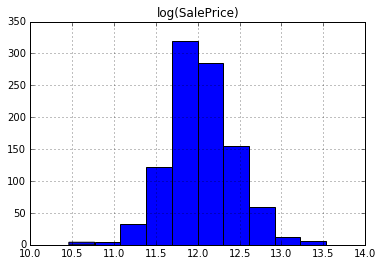

In [19]:
# Check log transform - looks good
%matplotlib inline
train['SalePrice'].log().as_data_frame().hist()

# Execute log transform
train['SalePrice'] = train['SalePrice'].log()
valid['SalePrice'] = valid['SalePrice'].log()
print(train[0:3, 'SalePrice'])

In [20]:
half_train, other_half_train = train.split_frame([0.5], seed=12345)
half_valid, other_half_valid = valid.split_frame([0.5], seed=12345)
print(half_train.shape)
print(half_valid.shape)
print(other_half_train.shape)
print(other_half_valid.shape)
# no idea why this works better, but it does ... 
# could be a lucky split that happens to be more representative of test data
# could be that it just prevents overfitting

(504, 3205)
(230, 3205)
(497, 3205)
(229, 3205)


In [23]:
def glm_grid(X, y, train, valid):
    
    """ Wrapper function for penalized GLM with alpha and lambda search.
    
    :param X: List of inputs.
    :param y: Name of target variable.
    :param train: Name of training H2OFrame.
    :param valid: Name of validation H2OFrame.
    :return: Best H2Omodel from H2OGeneralizedLinearEstimator

    """
    
    alpha_opts = [0.01, 0.25, 0.5, 0.99] # always keep some L2
    hyper_parameters = {"alpha":alpha_opts}

    # initialize grid search
    grid = H2OGridSearch(
        H2OGeneralizedLinearEstimator(
            family="gaussian",
            lambda_search=True,
            seed=12345),
        hyper_params=hyper_parameters)
    
    # train grid
    grid.train(y=y,
               x=X, 
               training_frame=train,
               validation_frame=valid)

    # show grid search results
    print(grid.show())

    best = grid.get_grid()[0]
    print(best)
    
    # plot top frame values
    yhat_frame = valid.cbind(best.predict(valid))
    print(yhat_frame[0:10, [y, 'predict']])

    # plot sorted predictions
    yhat_frame_df = yhat_frame[[y, 'predict']].as_data_frame()
    yhat_frame_df.sort_values(by='predict', inplace=True)
    yhat_frame_df.reset_index(inplace=True, drop=True)
    _ = yhat_frame_df.plot(title='Ranked Predictions Plot')
    
    # select best model
    return best

In [27]:
import re
import time

def gen_submission(model, test=test):

    """ Generates submission file for Kaggle House Prices contest.
    
    :param model: Model with which to score test data.
    :param test: Test data.
    
    """
    
    # create time stamp
    time_stamp = re.sub('[: ]', '_', time.asctime())

    # create predictions column
    sub = test['Id'].cbind(model.predict(test).exp())
    sub.columns = ['Id', 'SalePrice']
    
    # save file for submission
    sub_fname = '/home/youdan/Documents/ML_House price/submission_' + str(time_stamp) + '.csv'
    h2o.download_csv(sub, sub_fname)

In [28]:
import os

def pred_blender(dir_, files):
    
    """ Performs simple blending of prediction files. 
    
    :param dir_: Directory in which files to be read are stored.
    :param files: List of prediction files to be blended.
    
    """
    
    # read predictions in files list and cbind
    for i, file in enumerate(files):
        if i == 0:
            df = pd.read_csv(dir_ + os.sep + file).drop('SalePrice', axis=1)
        col = pd.read_csv(dir_ + os.sep + file).drop('Id', axis=1)
        col.columns = ['SalePrice' + str(i)]
        df = pd.concat([df, col], axis=1)
        
    # create mean prediction    
    df['mean'] = df.iloc[:, 1:].mean(axis=1)
    print(df.head())
        
    # create time stamp
    time_stamp = re.sub('[: ]', '_', time.asctime())        
        
    # write new submission file    
    df = df[['Id', 'mean']]
    df.columns = ['Id', 'SalePrice']
    
    # save file for submission
    sub_fname = '/home/youdan/Documents/ML_House price/submission_' + str(time_stamp) + '.csv'
    df.to_csv(sub_fname, index=False)

glm Grid Build progress: |████████████████████████████████████████████████| 100%
      alpha                                                      model_ids  \
0    [0.99]  Grid_GLM_py_288_sid_9558_model_python_1498169729571_2_model_3   
1     [0.5]  Grid_GLM_py_288_sid_9558_model_python_1498169729571_2_model_2   
2    [0.25]  Grid_GLM_py_288_sid_9558_model_python_1498169729571_2_model_1   
3    [0.01]  Grid_GLM_py_288_sid_9558_model_python_1498169729571_2_model_0   

   residual_deviance  
0  4.025940991543425  
1  4.037235202840872  
2  4.058507339499793  
3  4.491994155264091  
None
Model Details
H2OGeneralizedLinearEstimator :  Generalized Linear Modeling
Model Key:  Grid_GLM_py_288_sid_9558_model_python_1498169729571_2_model_3


ModelMetricsRegressionGLM: glm
** Reported on train data. **

MSE: 0.02156440483938825
RMSE: 0.14684823744052308
MAE: 0.09686367637083071
RMSLE: 0.01136422834169376
R^2: 0.8623195698871438
Mean Residual Deviance: 0.02156440483938825
Null degrees of freedom:

,timestamp,duration,iteration,lambda,predictors,deviance_train,deviance_test
,2017-06-22 15:35:30,0.000 sec,0,.31E0,2,0.1472858,0.1420261
,2017-06-22 15:35:30,0.001 sec,0,.3E0,2,0.1387711,0.1340858
,2017-06-22 15:35:30,0.003 sec,0,.29E0,2,0.1310096,0.1268453
,2017-06-22 15:35:30,0.006 sec,0,.27E0,2,0.1239348,0.1202429
,2017-06-22 15:35:30,0.009 sec,0,.26E0,2,0.1174861,0.1142224
---,---,---,---,---,---,---,---
,2017-06-22 15:35:31,0.695 sec,0,.39E-2,28,0.0211140,0.0177064
,2017-06-22 15:35:31,0.698 sec,0,.38E-2,29,0.0210799,0.0177301
,2017-06-22 15:35:31,0.700 sec,0,.36E-2,30,0.0210495,0.0177502
,2017-06-22 15:35:31,0.712 sec,0,.34E-2,30,0.0210200,0.0177665



See the whole table with table.as_data_frame()

glm prediction progress: |████████████████████████████████████████████████| 100%


SalePrice,predict
11.8494,11.9833
12.2061,12.3454
11.6784,11.6651
11.914,11.8164
12.6758,12.4798
12.861,12.7562
12.1035,12.0074
11.2898,11.3823
11.7714,11.7068
11.5843,11.4633



glm prediction progress: |████████████████████████████████████████████████| 100%


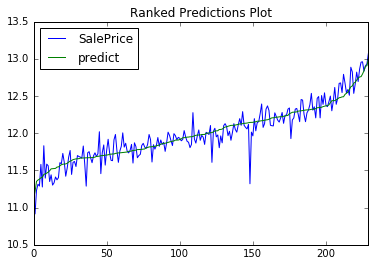

In [29]:
glm0_0 = glm_grid(original_nums, 'SalePrice', half_train, half_valid)
gen_submission(glm0_0) # Valid RMSE: ~0.1323, ~0.1445 on public leaderboard

glm Grid Build progress: |████████████████████████████████████████████████| 100%
      alpha                                                      model_ids  \
0    [0.99]  Grid_GLM_py_290_sid_9558_model_python_1498169729571_3_model_3   
1     [0.5]  Grid_GLM_py_290_sid_9558_model_python_1498169729571_3_model_2   
2    [0.25]  Grid_GLM_py_290_sid_9558_model_python_1498169729571_3_model_1   
3    [0.01]  Grid_GLM_py_290_sid_9558_model_python_1498169729571_3_model_0   

    residual_deviance  
0  3.3933211971158057  
1  3.4022965382962496  
2   3.412497153328939  
3  3.7916030401799707  
None
Model Details
H2OGeneralizedLinearEstimator :  Generalized Linear Modeling
Model Key:  Grid_GLM_py_290_sid_9558_model_python_1498169729571_3_model_3


ModelMetricsRegressionGLM: glm
** Reported on train data. **

MSE: 0.022272602172885826
RMSE: 0.14924008232671887
MAE: 0.10217670666125683
RMSLE: 0.011407191199535444
R^2: 0.854201320285019
Mean Residual Deviance: 0.022272602172885826
Null degrees of f

,timestamp,duration,iteration,lambda,predictors,deviance_train,deviance_test
,2017-06-22 15:46:05,0.000 sec,0,.3E0,2,0.1442675,0.1766220
,2017-06-22 15:46:05,0.002 sec,0,.28E0,2,0.1365238,0.1655749
,2017-06-22 15:46:05,0.010 sec,0,.27E0,2,0.1294652,0.1554957
,2017-06-22 15:46:05,0.023 sec,0,.26E0,2,0.1230313,0.1462994
,2017-06-22 15:46:05,0.025 sec,0,.25E0,2,0.1171668,0.1379085
---,---,---,---,---,---,---,---
,2017-06-22 15:46:06,0.491 sec,0,.38E-2,27,0.0219279,0.0149371
,2017-06-22 15:46:06,0.498 sec,0,.36E-2,27,0.0218700,0.0149759
,2017-06-22 15:46:06,0.507 sec,0,.34E-2,28,0.0218168,0.0150147
,2017-06-22 15:46:06,0.510 sec,0,.33E-2,28,0.0217677,0.0150506



See the whole table with table.as_data_frame()

glm prediction progress: |████████████████████████████████████████████████| 100%


SalePrice,predict
11.7906,11.8534
11.9117,11.9847
11.9767,11.9344
11.8451,11.8394
11.1346,11.3083
11.8845,11.8418
11.9382,11.907
11.8565,11.7382
11.9704,12.0465
12.6667,12.5716



glm prediction progress: |████████████████████████████████████████████████| 100%


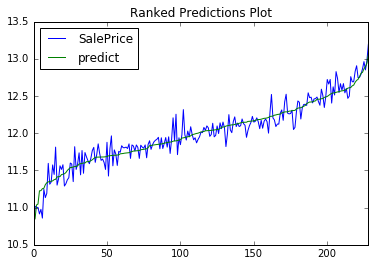

In [30]:
glm0_1 = glm_grid(original_nums, 'SalePrice', other_half_train, other_half_valid)
gen_submission(glm0_1) # Valid RMSE: 0.1492

glm Grid Build progress: |████████████████████████████████████████████████| 100%
      alpha                                                      model_ids  \
0    [0.99]  Grid_GLM_py_290_sid_9558_model_python_1498169729571_4_model_3   
1     [0.5]  Grid_GLM_py_290_sid_9558_model_python_1498169729571_4_model_2   
2    [0.25]  Grid_GLM_py_290_sid_9558_model_python_1498169729571_4_model_1   
3    [0.01]  Grid_GLM_py_290_sid_9558_model_python_1498169729571_4_model_0   

    residual_deviance  
0  3.4608118526528804  
1  3.4828956211591198  
2  3.5017586899430517  
3   3.809841366471101  
None
Model Details
H2OGeneralizedLinearEstimator :  Generalized Linear Modeling
Model Key:  Grid_GLM_py_290_sid_9558_model_python_1498169729571_4_model_3


ModelMetricsRegressionGLM: glm
** Reported on train data. **

MSE: 0.012019552402364653
RMSE: 0.10963371927634606
MAE: 0.07904242103741424
RMSLE: 0.008535306613288952
R^2: 0.9213188087576417
Mean Residual Deviance: 0.012019552402364653
Null degrees of 

,timestamp,duration,iteration,lambda,predictors,deviance_train,deviance_test
,2017-06-22 15:52:00,0.000 sec,0,.31E0,3,0.1435965,0.1781689
,2017-06-22 15:52:00,0.101 sec,0,.29E0,3,0.1346193,0.1670832
,2017-06-22 15:52:00,0.248 sec,0,.28E0,3,0.1264427,0.1569494
,2017-06-22 15:52:00,0.334 sec,0,.27E0,5,0.1184378,0.1468388
,2017-06-22 15:52:01,0.421 sec,0,.26E0,5,0.1107316,0.1370611
---,---,---,---,---,---,---,---
,2017-06-22 15:52:15,14.743 sec,0,.39E-2,87,0.0093247,0.0164268
,2017-06-22 15:52:15,15.038 sec,0,.37E-2,94,0.0092351,0.0164405
,2017-06-22 15:52:15,15.246 sec,0,.35E-2,96,0.0091355,0.0164636
,2017-06-22 15:52:16,15.506 sec,0,.34E-2,99,0.0090208,0.0166055



See the whole table with table.as_data_frame()

glm prediction progress: |████████████████████████████████████████████████| 100%


SalePrice,predict
11.7906,11.7273
11.9117,11.8989
11.9767,11.8275
11.8451,11.7022
11.1346,11.1499
11.8845,11.8045
11.9382,11.907
11.8565,11.742
11.9704,11.9711
12.6667,12.5146



glm prediction progress: |████████████████████████████████████████████████| 100%


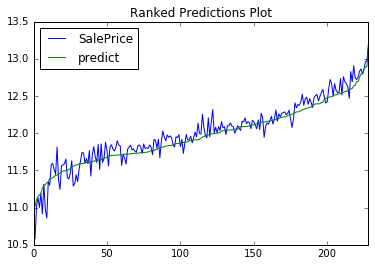

In [31]:
glm2_1 = glm_grid(encoded_combined_nums, 'SalePrice', other_half_train, other_half_valid)
gen_submission(glm2_1) # Valid RMSE: ~0.1229